In [79]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from xgboost import XGBRegressor  # Explicitly import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")

In [80]:
df = pd.read_csv("train_imputed.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Set Datetime as index
df.set_index('Datetime', inplace=True)
df.head()


,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00+00:00,26.212347,28.696304,45.618517,-0.965618,3.574269,3.548916,63.957929,58.944045,968.835706,79.139695,78.491839,39.490876,38.122456,252.00,3.976499,8.742512,2.0,252.00,3.042750
2018-01-01 06:40:00+00:00,59.632658,29.052567,45.595080,-0.965893,3.556906,3.580123,64.160004,58.937220,964.273849,79.135885,78.489842,39.651542,38.402724,255.00,11.091660,8.618720,2.0,255.00,3.424814
2018-01-01 06:50:00+00:00,40.889650,28.984758,45.600027,-0.973232,3.551043,3.555894,64.146156,58.947189,809.641977,79.112367,78.484888,39.549674,38.482827,264.75,4.234497,7.266462,2.0,264.75,3.507172
2018-01-01 10:40:00+00:00,34.398111,30.282058,45.605075,-0.985792,3.563948,3.556097,64.069310,58.894958,878.871191,79.144295,78.471170,39.265243,39.601769,283.75,5.347792,7.904786,2.0,283.75,3.442212
2018-01-01 12:00:00+00:00,29.797653,29.333519,45.611618,-0.979451,3.556985,3.572853,63.990601,58.944563,997.631304,79.145707,78.431822,39.684512,38.677664,274.00,6.022326,8.916453,2.0,274.00,3.031363


# Formatting the dataset into days

In [81]:
# Define column groups
sum_cols = ['ActivePower', 'ReactivePower']
mode_cols = ['TurbineStatus']
median_cols = [col for col in df.columns if col not in sum_cols and col not in mode_cols]

# Create a safe mode function that won't fail if mode is empty
def safe_mode(x):
    mode_result = x.mode()
    if len(mode_result) > 0:
        return mode_result[0]
    elif len(x) > 0:
        # Return first value if no mode exists
        return x.iloc[0]
    else:
        # Return None if series is empty
        return None

# Define complete aggregation rules
rules = {
    **{col: 'sum' for col in sum_cols},
    **{col: 'mean' for col in median_cols},
    **{col: safe_mode for col in mode_cols},
}

# Make a copy of the dataframe
df_daily = df.copy()

# Apply aggregation with rules
df_daily = df_daily.resample('D').agg(rules)

# Fill any remaining NaN values in mean columns
for col in median_cols:
    if df_daily[col].isna().any():
        # Forward fill, then backward fill to handle any remaining NaNs
        df_daily[col] = df_daily[col].fillna(method='ffill').fillna(method='bfill')

# Reset timezone if needed
df_daily.index = df_daily.index.tz_localize(None)
df_daily.head()

,ActivePower,ReactivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,RotorRPM,WindDirection,WindSpeed,TurbineStatus
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,24178.923956,4887.431384,25.537023,45.439078,-0.971301,3.561990,3.561562,64.735442,58.935610,1105.795329,79.165380,78.484543,36.895624,36.433419,276.727612,9.911930,276.727612,5.234498,2.0
2018-01-02,40070.788083,8089.181950,25.356903,45.644371,-0.756658,3.561742,3.559797,65.684152,59.002960,1152.037103,79.164356,78.499255,36.928021,36.342143,274.105603,10.327079,274.105603,5.344286,2.0
2018-01-03,40129.409441,8090.072351,24.487208,45.644907,-0.712630,3.559449,3.561402,65.458412,58.965957,1136.890060,79.156347,78.501100,36.423227,35.911438,286.369130,10.199205,286.369130,5.285910,2.0
2018-01-04,47287.251399,9498.206651,24.975148,45.663822,-0.801230,3.560415,3.561800,65.127875,58.958554,1099.175306,79.155531,78.490024,36.890005,36.170630,284.445471,9.853174,284.445471,5.095768,2.0
2018-01-05,30015.577400,6041.641568,23.549267,45.530323,-0.908139,3.561643,3.563124,64.861777,58.969959,1086.319799,79.163273,78.488968,35.935004,35.516970,292.013293,9.740967,292.013293,4.953079,2.0


In [82]:
df_daily.isnull().sum()

ActivePower                      0
ReactivePower                    0
AmbientTemperatue                0
BearingShaftTemperature          0
Blade1PitchAngle                 0
Blade2PitchAngle                 0
Blade3PitchAngle                 0
GearboxBearingTemperature        0
GearboxOilTemperature            0
GeneratorRPM                     0
GeneratorWinding1Temperature     0
GeneratorWinding2Temperature     0
HubTemperature                   0
MainBoxTemperature               0
NacellePosition                  0
RotorRPM                         0
WindDirection                    0
WindSpeed                        0
TurbineStatus                   72
dtype: int64

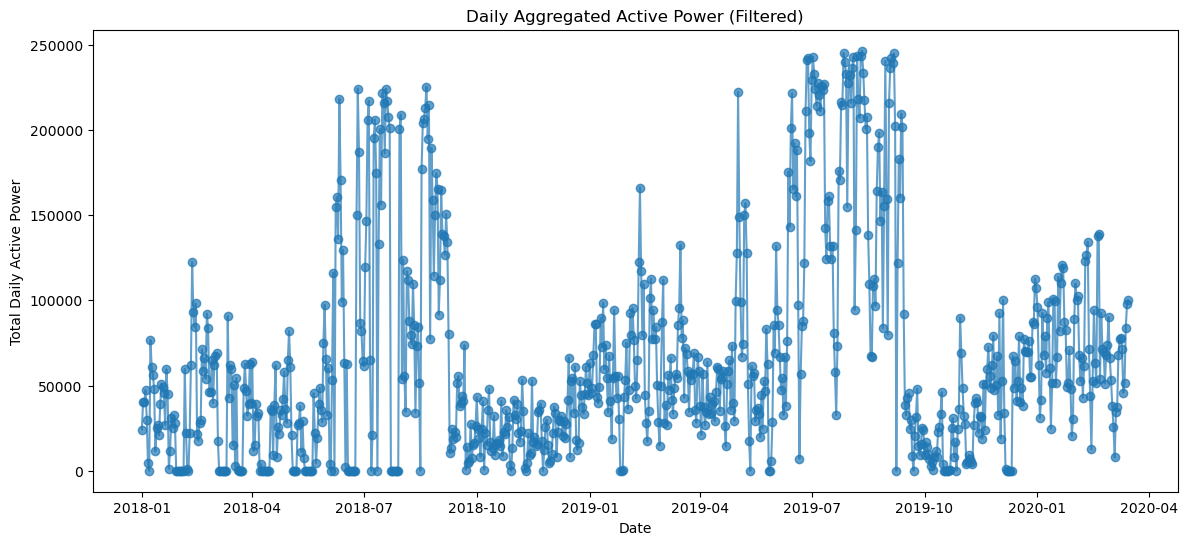

In [83]:
# Plot the adjusted daily ActivePower after filtering
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily.ActivePower, marker='o', linestyle='-', alpha=0.7)
plt.title('Daily Aggregated Active Power (Filtered)')
plt.xlabel('Date')
plt.ylabel('Total Daily Active Power')
plt.show()

## Prophet 

In [84]:
# Split test and train sets
train_size = int(len(df_daily) * 0.85) 
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

In [85]:
# Create dataset
df_prophet = train['ActivePower'].reset_index()
df_prophet.rename(columns={'Datetime': 'ds', 'ActivePower': 'y'}, inplace=True)

# Ensure ds is datetime type without timezone
if df_prophet['ds'].dt.tz is not None:
    df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

df_prophet.head()

,ds,y
0,2018-01-01,24178.923956
1,2018-01-02,40070.788083
2,2018-01-03,40129.409441
3,2018-01-04,47287.251399
4,2018-01-05,30015.577400


In [86]:
model_prophet = Prophet(
    changepoint_prior_scale=0.01,
    yearly_seasonality=True, 
    weekly_seasonality=True,  
    daily_seasonality=True
)
# model_prophet.add_seasonality(name='yearly', period=365, fourier_order=15)
model_prophet.add_seasonality(name='quarterly', period=91, fourier_order=20)
# model_prophet.add_seasonality(name='weekly', period=7, fourier_order=6)
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=len(test) + 15, freq='D')

# Forecast
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

10:46:14 - cmdstanpy - INFO - Chain [1] start processing
10:46:14 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
805,2020-03-16,85421.300501,36975.270344,137888.246096
806,2020-03-17,85192.263109,31761.305236,141911.657744
807,2020-03-18,82562.973718,30532.374051,134612.349604
808,2020-03-19,72557.808296,19239.715106,123888.205415
809,2020-03-20,56352.848253,819.901303,107730.087472
810,2020-03-21,53379.194904,1591.210916,104869.179621
811,2020-03-22,62434.424495,12436.795080,115919.714325
812,2020-03-23,93375.603081,38846.779890,147825.898916
813,2020-03-24,111040.000210,58346.370076,165254.081931
814,2020-03-25,110638.674600,57595.381838,165121.534603


In [88]:
y_true = test['ActivePower'].values
y_pred = forecast['yhat'].iloc[:len(test)].values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

47347.731646703985